In [1]:
# Imports of goods and services (IEAMGSN) QUARTERLY
# Net exports of goods and services (NA000374Q) QUARTERLY
# Government total expenditures (W068RCQ027SBEA) Quarterly - Observation: Seasonally Adjusted Annual Rate

# Continued Claims (Insured Unemployment) (CCSA) WEEKLY
# Initial Claims (ICSA) WEEKLY

In [2]:
# investpy.indices.search_indices(by='country', value='us')

In [1]:
!pip install -U statsmodels

import quandl
import investpy
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import datetime
import pandas_datareader as pdr
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from finpie.economic_data import oecd_data
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Displays all columns in the DataFrame
pd.set_option("display.max_columns", None)

In [2]:
# Reading in the OECD CLI data (Monthly)- amplitude adjusted 
oecd = oecd_data.OecdData(country_code = 'USA', freq = 'M')
cli = pd.DataFrame(oecd.cli(subject = 'amplitude'))

# Dropping columns and renaming the index and the column `cli`
cli.drop(['SUBJECT', 'Subject', 
          'Country', 'FREQUENCY', 
          'TIME', 'Unit Code', 
          'PowerCode Code'], axis=1, inplace=True)

cli.index.name = "Date"
cli.columns = ['cli']

# Changing and checking that the `cli.index` was changed to a datetime format
cli.index = pd.to_datetime(cli.index)
print(type(cli.index))
cli.tail()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,cli
Date,
2021-02-01,99.75359
2021-03-01,100.05380
2021-04-01,100.29900
2021-05-01,100.41510
2021-06-01,100.66020


In [3]:
# ISM_PMI.columns

In [4]:
# Pulling Monthly data from FRED
data_source = 'fred'
start = datetime.datetime (1960, 1, 1)      #  (2005, 5, 1)
end = datetime.datetime (2030, 12, 1)

# cli
ISM_PMI = quandl.get("ISm/MAN_PMI", authtoken=quandl.ApiConfig.api_key)
IND_PRO = quandl.get("FRED/IPMAN", authtoken=quandl.ApiConfig.api_key)
IND_PRO.columns = ['Ind_Pro']
DurGoods = pdr.DataReader('DGORDER', data_source, start, end)
DurGoods.index.names = ['Date']
DurGoods.columns = ['DurGoods']
NewOrd = pdr.DataReader('NEWORDER', data_source, start, end)
NewOrd.index.names = ['Date']
NewOrd.columns = ['NewOrders']
RetSales = pdr.DataReader('RSAFS', data_source, start, end)
RetSales.index.names = ['Date']
RetSales.columns = ['RetailSales']
pce = pdr.DataReader('PCE', data_source, start, end)
pce.index.names = ['Date']
pce.columns = ['PCE']
WeekHours = pdr.DataReader('CEU4200000002', data_source, start, end)
WeekHours.index.names = ['Date']
WeekHours.columns = ['WeeklyHours']

raw_indicators = pd.merge(cli['cli'], ISM_PMI, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, IND_PRO, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, DurGoods, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, NewOrd, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, RetSales, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, pce, left_index=True, right_index=True)
raw_indicators = pd.merge(raw_indicators, WeekHours, left_index=True, right_index=True)

symbols = ['cli', 'PMI', 
           'Ind_Pro', 'DurGoods', 
           'NewOrders', 'RetailSales', 
           'PCE', 'WeeklyHours']

for symbol in symbols:
    raw_indicators[symbol + '_prev'] = raw_indicators[symbol].shift(1)
    raw_indicators[symbol + '_ret'] = raw_indicators[symbol] / raw_indicators[symbol + '_prev'] - 1

pct_changes = raw_indicators[[symbol + '_ret' for symbol in symbols]].copy()
pct_changes.dropna(axis=0, how='all', inplace=True)
pct_changes.head()

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

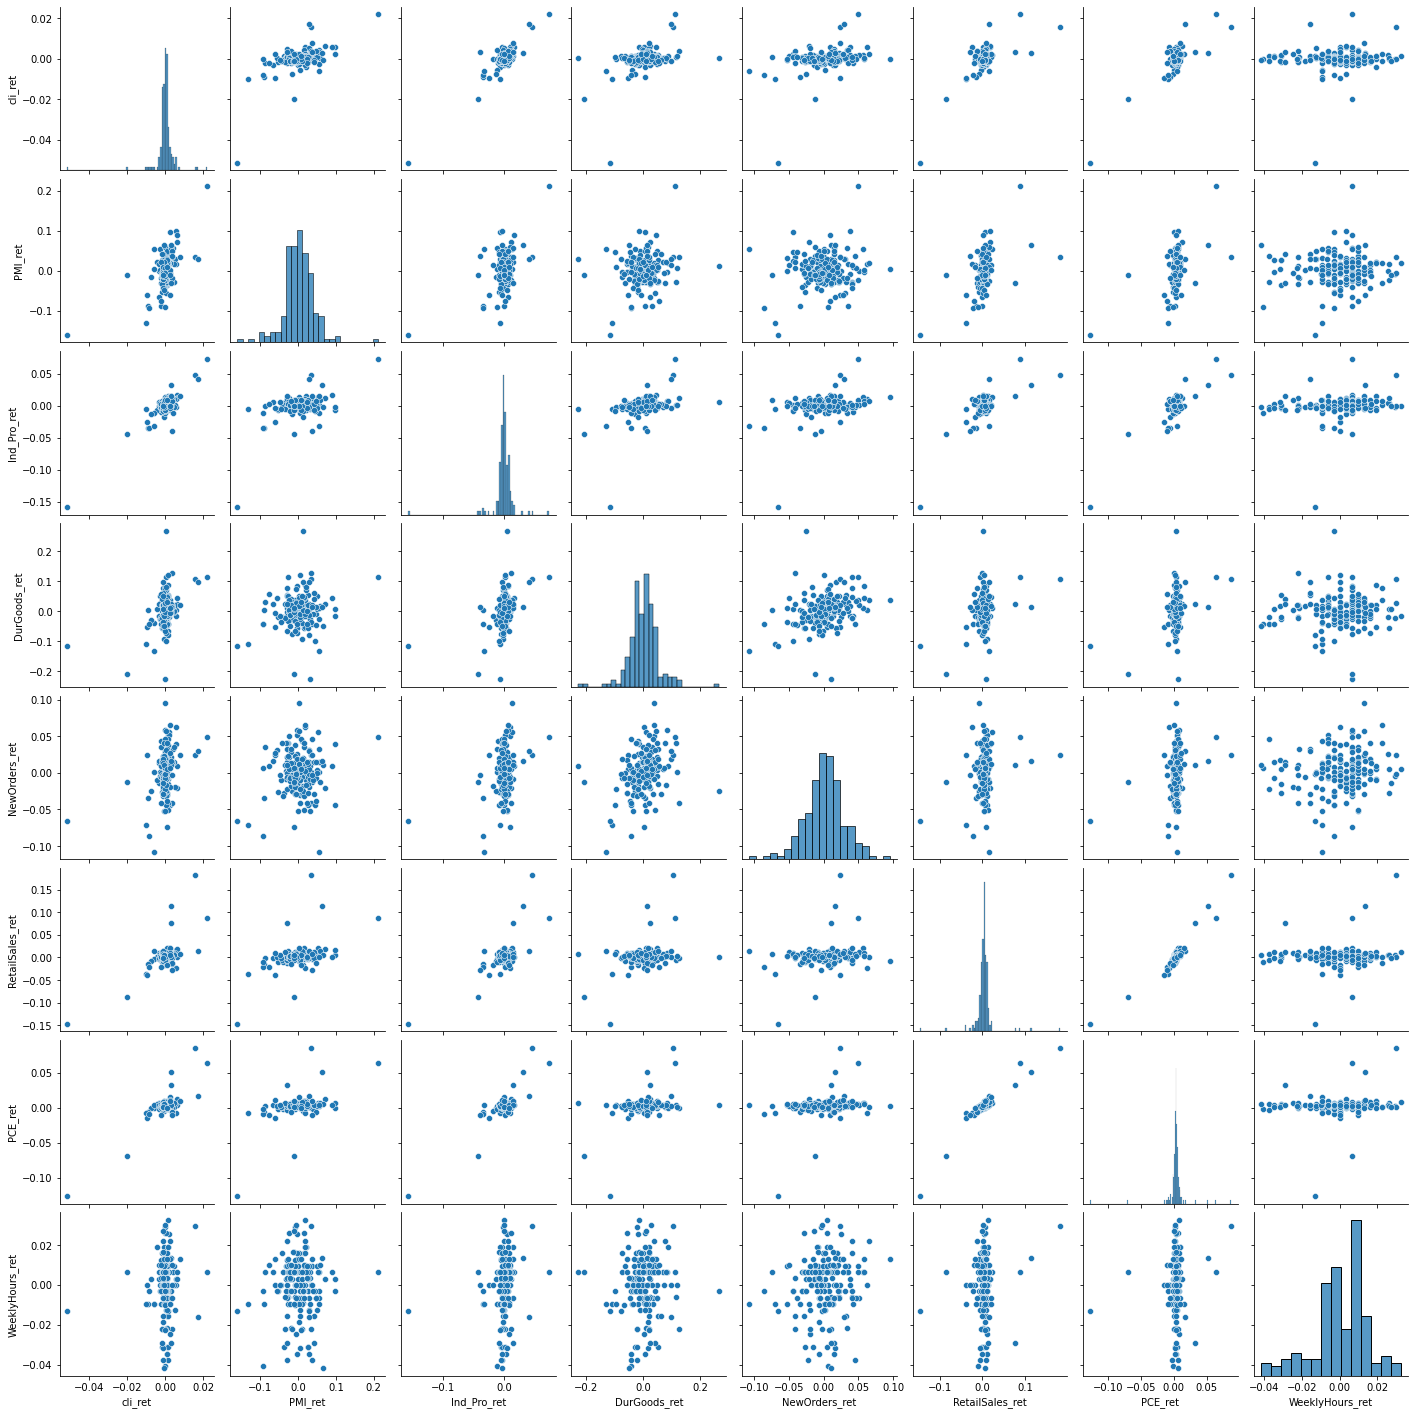

In [7]:
# sns.pairplot(pct_changes, kind="kde");
sns.pairplot(pct_changes);

In [8]:
pct_changes.mean()

cli_ret           -0.000028
PMI_ret            0.001386
Ind_Pro_ret       -0.000022
DurGoods_ret       0.002091
NewOrders_ret      0.001274
RetailSales_ret    0.003325
PCE_ret            0.003099
WeeklyHours_ret    0.000121
dtype: float64

In [9]:
pct_changes.std()

cli_ret            0.005320
PMI_ret            0.039767
Ind_Pro_ret        0.016437
DurGoods_ret       0.052786
NewOrders_ret      0.028518
RetailSales_ret    0.023590
PCE_ret            0.014579
WeeklyHours_ret    0.014350
dtype: float64

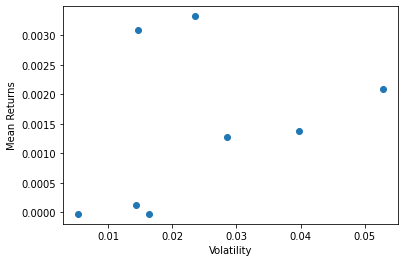

In [10]:
import matplotlib.pyplot as plt
plt.scatter(pct_changes.std(), pct_changes.mean())
plt.xlabel('Volatility')
plt.ylabel('Mean Returns')
plt.show()

In [11]:
pct_changes.corr()

,cli_ret,PMI_ret,Ind_Pro_ret,DurGoods_ret,NewOrders_ret,RetailSales_ret,PCE_ret,WeeklyHours_ret
cli_ret,1.000000,0.558579,0.884644,0.415364,0.337841,0.715630,0.836292,0.072142
PMI_ret,0.558579,1.000000,0.473628,0.161692,0.101501,0.453981,0.451945,0.026144
Ind_Pro_ret,0.884644,0.473628,1.000000,0.419973,0.338545,0.734062,0.843058,0.160781
DurGoods_ret,0.415364,0.161692,0.419973,1.000000,0.309834,0.320433,0.356812,0.064394
NewOrders_ret,0.337841,0.101501,0.338545,0.309834,1.000000,0.201239,0.242244,0.115197
RetailSales_ret,0.715630,0.453981,0.734062,0.320433,0.201239,1.000000,0.937024,0.110937
PCE_ret,0.836292,0.451945,0.843058,0.356812,0.242244,0.937024,1.000000,0.116815
WeeklyHours_ret,0.072142,0.026144,0.160781,0.064394,0.115197,0.110937,0.116815,1.000000


In [12]:
pct_changes.cov()

,cli_ret,PMI_ret,Ind_Pro_ret,DurGoods_ret,NewOrders_ret,RetailSales_ret,PCE_ret,WeeklyHours_ret
cli_ret,0.000028,0.000118,0.000077,0.000117,0.000051,0.000090,0.000065,0.000006
PMI_ret,0.000118,0.001581,0.000310,0.000339,0.000115,0.000426,0.000262,0.000015
Ind_Pro_ret,0.000077,0.000310,0.000270,0.000364,0.000159,0.000285,0.000202,0.000038
DurGoods_ret,0.000117,0.000339,0.000364,0.002786,0.000466,0.000399,0.000275,0.000049
NewOrders_ret,0.000051,0.000115,0.000159,0.000466,0.000813,0.000135,0.000101,0.000047
RetailSales_ret,0.000090,0.000426,0.000285,0.000399,0.000135,0.000556,0.000322,0.000038
PCE_ret,0.000065,0.000262,0.000202,0.000275,0.000101,0.000322,0.000213,0.000024
WeeklyHours_ret,0.000006,0.000015,0.000038,0.000049,0.000047,0.000038,0.000024,0.000206


In [13]:
print("Pulling data from another file. Please wait......")
%run qoq_data.ipynb


# Pulling Monthly data from Quandl API
quandl.ApiConfig.api_key='1mEBe1BeVaAExprr7akA'

cli['cli%qoq'] = cli['cli'].pct_change() * 100
cli['cli%yoy'] = cli['cli'].pct_change(12) * 100
cli['cli_roc'] = roc(cli['cli'], 11)
cli['cli_roc%yoy'] = cli['cli%yoy'].diff().round(2)

# ISM-PMI  quandl.get("ISM/MAN_PMI")
ism_pmi = quandl.get("ISm/MAN_PMI", authtoken=quandl.ApiConfig.api_key)
# ism_pmi.index = ism_pmi.index.strftime('%Y-%m')
# ism_pmi.index = pd.PeriodIndex(ism_pmi.index, freq='Q')
                                       
ism_pmi['PMI%qoq'] = ism_pmi['PMI'].pct_change() * 100
ism_pmi['PMI_%yoy'] = ism_pmi['PMI'].pct_change(12) * 100
ism_pmi['PMI_roc'] = roc(ism_pmi['PMI'], 11)
ism_pmi['PMI_roc%yoy'] = ism_pmi['PMI_%yoy'].diff().round(2)

# ISM-Services quandl.get("ISM/NONMAN_NMI")
ism_services = quandl.get("ISM/NONMAN_NMI", authtoken=quandl.ApiConfig.api_key)
ism_services.columns = ['ISMServices']

# ism_services.index = ism_services.index.strftime('%Y-%m')
# ism_services.index = pd.PeriodIndex(ism_services.index, freq='Q')
                                       


# Industrial Production - IPMAN quandl.get("FRED/IPMAN")
ind_pro = quandl.get("FRED/IPMAN", authtoken=quandl.ApiConfig.api_key)
ind_pro.columns = ['Ind_Pro']

# ind_pro.index = ind_pro.index.strftime('%Y-%m')
# ind_pro.index = pd.PeriodIndex(ind_pro.index, freq='Q')

ind_pro['IndPro%qoq'] = ind_pro['Ind_Pro'].pct_change() * 100
ind_pro['IndPro%yoy'] = ind_pro['Ind_Pro'].pct_change(12) * 100
ind_pro['IndPro_roc'] = roc(ind_pro['Ind_Pro'], 11)
ind_pro['IndPro_roc%yoy'] = ind_pro['IndPro%yoy'].diff().round(2)

print("Almost done......")



# GDP Seasonally Adjusted annual rate
GDP = pdr.DataReader('GDPC1', data_source, start, end)
# GDP.index = GDP.index.strftime('%Y-%m')
# GDP.index = pd.PeriodIndex(GDP.index, freq='Q')
GDP.columns = ['GDP']

GDP['GDP%yoy'] = GDP['GDP'].pct_change(4) * 100
GDP['GDP_roc'] = roc(GDP['GDP'], 4)
GDP = GDP.round(2)


# Manufacturers' New Orders: Durable Goods (DGORDER)
DurableGoods = pdr.DataReader('DGORDER', data_source, start, end)
DurableGoods.index.names = ['Date']
DurableGoods.columns = ['DurGoods']

# DurableGoods.index = DurableGoods.index.strftime('%Y-%m')
# DurableGoods.index = pd.PeriodIndex(DurableGoods.index, freq='Q')

DurableGoods['DurGoods%qoq'] = DurableGoods['DurGoods'].pct_change() * 100
DurableGoods['DurGoods%yoy'] = DurableGoods['DurGoods'].pct_change(12) * 100
DurableGoods['DurGoods_roc'] = roc(DurableGoods['DurGoods'], 11)
DurableGoods['DurGoods_roc%yoy'] = DurableGoods['DurGoods%yoy'].diff().round(2)


# # Manufacturers' New Orders: Nondefense Capital Goods Excluding Aircraft (NEWORDER)
NewOrders = pdr.DataReader('NEWORDER', data_source, start, end)
NewOrders.index.names = ['Date']
NewOrders.columns = ['NewOrders']

# NewOrders.index = NewOrders.index.strftime('%Y-%m')
# NewOrders.index = pd.PeriodIndex(NewOrders.index, freq='Q')

NewOrders['NewOrders%qoq'] = NewOrders['NewOrders'].pct_change() * 100
NewOrders['NewOrders%yoy'] = NewOrders['NewOrders'].pct_change(12) * 100
NewOrders['NewOrders_roc'] = roc(NewOrders['NewOrders'], 11)
NewOrders['NewOrders_roc%yoy'] = NewOrders['NewOrders%yoy'].diff().round(2)

# Advance Retail Sales: Retail and Food Services, Total (RSAFS)
RetailSales = pdr.DataReader('RSAFS', data_source, start, end)
RetailSales.index.names = ['Date']
RetailSales.columns = ['RetailSales']

# RetailSales.index = RetailSales.index.strftime('%Y-%m')
# RetailSales.index = pd.PeriodIndex(RetailSales.index, freq='Q')

RetailSales['RetailSales%qoq'] = RetailSales['RetailSales'].pct_change() * 100
RetailSales['RetailSales%yoy'] = RetailSales['RetailSales'].pct_change(12) * 100
RetailSales['RetailSales_roc'] = roc(RetailSales['RetailSales'], 11)
RetailSales['RetailSales_roc%yoy'] = RetailSales['RetailSales%yoy'].diff().round(2)

# Not sure what the correlation is between GDP and Personal Consumption Expenditures...
# Will this be a better indicator for Inflation???
# Personal Consumption Expenditures (PCE) Monthly - Observation: Billions of Dollars, Seasonally Adjusted Annual Rate
PCE = pdr.DataReader('PCE', data_source, start, end)
PCE.index.names = ['Date']
PCE.columns = ['PCE']

# PCE.index = PCE.index.strftime('%Y-%m')
# PCE.index = pd.PeriodIndex(PCE.index, freq='Q')

PCE['PCE%qoq'] = PCE['PCE'].pct_change() * 100
PCE['PCE%yoy'] = PCE['PCE'].pct_change(12) * 100
PCE['PCE_roc'] = roc(PCE['PCE'], 11)
PCE['PCE_roc%yoy'] = PCE['PCE%yoy'].diff().round(2)

# Average Weekly Hours of All Employees, Retail Trade (CEU4200000002) : Not Seasonally adjusted
WeeklyHours = pdr.DataReader('CEU4200000002', data_source, start, end)
WeeklyHours.index.names = ['Date']
WeeklyHours.columns = ['WeeklyHours']

# WeeklyHours.index = WeeklyHours.index.strftime('%Y-%m')
# WeeklyHours.index = pd.PeriodIndex(WeeklyHours.index, freq='Q')


print("Done!")
print("----------------------")


# momGDP = pd.merge(GDP, ism_pmi, left_index=True, right_index=True)

df_mom = [ism_pmi, 
          ism_services]

momGDP = pd.concat(df_mom, join="outer", axis=1)

momGDP['ISMServices'] = momGDP['ISMServices'].fillna(50)
momGDP['ISMServices%qoq'] = momGDP['ISMServices'].pct_change() * 100
momGDP['ISMServices_%yoy'] = momGDP['ISMServices'].pct_change(12) * 100
momGDP['ISMServices_roc'] = roc(momGDP['ISMServices'], 11)
momGDP['ISMServices_roc%yoy'] = momGDP['ISMServices_%yoy'].diff().round(2)

# print(momGDP)

          
df_mom = [momGDP,
          cli,
          ind_pro, 
          DurableGoods, 
          NewOrders, 
          RetailSales, 
          PCE, 
          WeeklyHours]

momGDP = pd.concat(df_mom, join="outer", axis=1)

momGDP['WeeklyHours'] = momGDP['WeeklyHours'].fillna(momGDP['WeeklyHours'].mean())
momGDP['WeeklyHours%qoq'] = momGDP['WeeklyHours'].pct_change() * 100
momGDP['WeeklyHours%yoy'] = momGDP['WeeklyHours'].pct_change(12) * 100
momGDP['WeeklyHours_roc'] = roc(momGDP['WeeklyHours'], 11)
momGDP['WeeklyHours_roc%yoy'] = momGDP['WeeklyHours%yoy'].diff().round(2)

# momGDP = pd.merge(momGDP, ism_services, left_index=True, right_index=True).fillna(50)
# momGDP = pd.merge(momGDP, ind_pro, left_index=True, right_index=True)
# momGDP = pd.merge(momGDP, DurableGoods, left_index=True, right_index=True)
# momGDP = pd.merge(momGDP, NewOrders, left_index=True, right_index=True)
# momGDP = pd.merge(momGDP, RetailSales, left_index=True, right_index=True)
# momGDP = pd.merge(momGDP, PCE, left_index=True, right_index=True)
# momGDP = pd.merge(momGDP, WeeklyHours, left_index=True, right_index=True)

# momGDP = pd.concat(df_mom, join="outer", axis=1)
print(momGDP.shape)
print("DataFrame Name: momGDP")

start = '1990-01-01'
mask = momGDP.index >= start
momGDP = momGDP[mask]

momGDP = (momGDP.ffill() + momGDP.bfill())/2
momGDP = momGDP.round(3)

# momGDP.index = momGDP.index.strftime('%Y-%m')
# momGDP.index = pd.PeriodIndex(momGDP.index, freq='Q')

momGDP.tail(5)

Pulling data from another file. Please wait......
Almost done......
Done!
----------------------
(883, 45)
DataFrame Name: momGDP


,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-01,64.7,6.414,30.181,23.768,9.31,63.7,15.190,18.843,39.486,21.31,100.054,0.301,3.253,5.579,2.34,97.959,3.162,3.433,20.396,7.54,249467.0,1.302,36.308,13.595,29.66,73318.0,1.619,14.375,8.434,3.18,623119.0,11.277,29.706,26.577,23.21,15458.9,5.165,12.329,18.557,12.91,30.400,1.333,-0.977,2.636,0.66
2021-04-01,60.7,-6.182,45.564,-9.684,15.38,62.7,-1.570,50.721,-10.324,31.88,100.299,0.245,9.116,-1.314,5.86,97.574,-0.393,22.465,-5.008,19.03,247644.0,-0.731,53.024,-10.795,16.72,75315.0,2.724,25.793,0.335,11.42,628751.0,0.904,53.422,-15.798,23.72,15630.0,1.107,30.014,-7.168,17.69,30.800,1.316,1.650,-1.620,2.63
2021-05-01,61.2,0.824,41.995,-18.336,-3.57,64.0,2.073,40.969,-19.821,-9.75,100.415,0.116,7.553,-2.070,-1.56,98.472,0.920,18.018,-6.195,-4.45,255529.0,3.184,42.783,-7.592,-10.24,75742.0,0.567,23.566,-4.218,-2.23,617938.0,-1.720,27.595,-10.121,-25.83,15616.2,-0.088,19.590,-6.259,-10.42,31.200,1.299,0.000,0.651,-1.65
2021-06-01,60.6,-0.980,16.092,-3.818,-25.90,60.1,-6.094,6.372,-6.464,-34.60,100.660,0.244,5.484,-1.457,-2.07,98.426,-0.047,9.866,-4.084,-8.15,257860.0,0.912,29.431,-8.440,-13.35,76283.0,0.714,18.636,-2.184,-4.93,621340.0,0.551,17.978,-0.890,-9.62,15771.6,0.995,13.552,-0.722,-6.04,30.900,-0.962,-1.592,0.639,-1.59
2021-07-01,59.5,-1.815,10.801,-5.309,-5.29,64.1,6.656,13.251,5.389,6.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.253,1.141,1.141,-0.151,2.73


In [14]:
# Less a few rows that had NaNs
mom_adjusted = momGDP.dropna()

In [15]:
mom_adjusted.tail(1)

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-01,60.6,-0.98,16.092,-3.818,-25.9,60.1,-6.094,6.372,-6.464,-34.6,100.66,0.244,5.484,-1.457,-2.07,98.426,-0.047,9.866,-4.084,-8.15,257860.0,0.912,29.431,-8.44,-13.35,76283.0,0.714,18.636,-2.184,-4.93,621340.0,0.551,17.978,-0.89,-9.62,15771.6,0.995,13.552,-0.722,-6.04,30.9,-0.962,-1.592,0.639,-1.59


In [16]:
momGDP['ISMServices'].shape

(379,)

In [17]:
momGDP.corr()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
PMI,1.000000,0.180189,0.671383,0.007566,0.028969,0.534156,0.097520,0.480016,0.057583,0.043629,0.647775,0.241722,0.762316,0.068725,0.091732,0.239172,0.302970,0.524721,0.220060,0.232240,0.234836,0.138458,0.606429,0.095738,0.074980,0.144382,0.180758,0.592596,0.122120,0.116285,0.210261,0.123463,0.533515,0.084494,0.073069,0.268812,0.137671,0.299730,0.138898,0.126477,-0.057550,0.012038,0.169747,0.001995,0.007165
PMI%qoq,0.180189,1.000000,0.233526,0.713526,0.689725,0.034849,0.338172,0.052128,0.244162,0.185173,-0.055887,0.493204,0.047734,0.455687,0.363592,-0.048916,0.351621,-0.134097,0.352279,0.243714,-0.082998,0.059860,-0.111281,0.123197,0.008571,-0.105792,-0.011960,-0.160365,0.083350,-0.019204,0.008930,0.262005,-0.006865,0.272704,0.145596,0.006761,0.273098,-0.086704,0.259961,0.137362,-0.011625,0.019916,0.015863,0.021306,0.020779
PMI_%yoy,0.671383,0.233526,1.000000,-0.015464,0.196728,0.206728,0.105340,0.594111,0.040889,0.114458,0.270771,0.275751,0.784617,0.140281,0.263871,-0.040727,0.256957,0.303109,0.275406,0.372944,-0.069386,0.133184,0.371271,0.159656,0.151927,-0.113038,0.166691,0.242120,0.205860,0.206095,0.015746,0.085840,0.350098,0.056881,0.104789,0.025747,0.105624,0.163107,0.104256,0.158163,-0.075850,0.014018,0.099573,0.003981,0.016521
PMI_roc,0.007566,0.713526,-0.015464,1.000000,0.545166,-0.028872,0.239782,-0.100044,0.330709,0.211127,-0.106273,0.380771,-0.107344,0.577625,0.429522,-0.047586,0.254247,-0.267500,0.425187,0.233523,-0.047119,-0.011294,-0.215475,0.071418,0.084543,-0.056202,-0.075059,-0.254111,0.004383,0.001229,0.025451,0.225893,-0.084103,0.348072,0.272223,-0.003462,0.213109,-0.152405,0.328075,0.223344,-0.020373,0.024438,-0.021127,0.032016,0.048921
PMI_roc%yoy,0.028969,0.689725,0.196728,0.545166,1.000000,-0.042473,0.173788,0.023293,0.193831,0.310761,-0.094631,0.331702,-0.030422,0.440632,0.510623,-0.047290,0.181683,-0.202635,0.287665,0.340469,-0.051255,-0.010637,-0.212623,0.129021,0.026234,-0.035260,0.047729,-0.229817,0.156143,0.040110,0.022319,0.160054,0.013432,0.143156,0.260687,-0.002620,0.159127,-0.061782,0.144898,0.245324,0.005349,0.041772,0.032897,0.029824,0.066377
ISMServices,0.534156,0.034849,0.206728,-0.028872,-0.042473,1.000000,0.236606,0.495099,0.129259,0.131306,0.287741,0.186457,0.351250,0.078970,0.117983,0.424703,0.180072,0.200683,0.140764,0.170806,0.641749,0.069540,0.335066,0.033795,0.034878,0.521800,0.058750,0.225985,0.053957,0.053545,0.705244,0.126020,0.395312,0.062492,0.078052,0.680833,0.133450,0.140204,0.119964,0.149443,-0.172954,0.006219,0.050417,-0.011106,0.042071
ISMServices%qoq,0.097520,0.338172,0.105340,0.239782,0.173788,0.236606,1.000000,0.265171,0.743090,0.667921,-0.001459,0.506407,0.049747,0.462297,0.385083,0.009171,0.487582,-0.014901,0.476767,0.366438,0.007934,0.126351,0.009416,0.116827,0.075965,-0.011480,-0.004686,-0.048257,0.056448,-0.002751,0.055016,0.526351,0.125223,0.419875,0.357131,0.041256,0.543865,0.043710,0.468775,0.397358,-0.015569,0.001081,0.027589,0.010550,0.092462
ISMServices_%yoy,0.480016,0.052128,0.594111,-0.100044,0.023293,0.495099,0.265171,1.000000,-0.010489,0.346955,0.288002,0.258170,0.666129,0.061380,0.307855,0.074484,0.266013,0.458796,0.174421,0.409616,0.106655,0.095987,0.513145,0.053800,0.106964,0.106603,0.109255,0.349711,0.125233,0.133005,0.142896,0.124584,0.591647,-0.043795,0.158975,0.122252,0.165749,0.441787,0.036638,0.275609,0.015239,0.036285,0.216014,0.002789,0.054604
ISMServices_roc,0.057583,0.244162,0.040889,0.330709,0.1938

In [18]:
# qoqGDP = momGDP.copy()
# qoqGDP.index = qoqGDP.index.strftime('%Y-%m')
# qoqGDP.index = pd.PeriodIndex(qoqGDP.index, freq='Q')
# qoqGDP.tail(6)

In [19]:
# Should be momCLI, not momGDP
momGDP.dropna(inplace=True)

In [20]:
momGDP.head(6)

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-03-01,53.5,-3.080,-2.015,0.604,-6.76,50.0,0.0,0.0,0.0,0.0,100.035,-0.099,0.683,-0.266,-0.29,61.976,-0.195,4.160,-0.771,-1.28,126762.0,-1.624,5.613,-5.273,-6.89,36895.0,-0.181,4.643,-2.242,-4.53,172306.0,-0.828,5.244,-1.433,-0.56,4352.5,-0.064,5.720,-0.416,-0.52,31.253,0.0,0.0,0.0,0.0
1993-04-01,50.2,-6.168,-4.563,-12.093,-2.55,50.0,0.0,0.0,0.0,0.0,99.890,-0.145,0.369,-0.251,-0.31,62.301,0.525,4.105,-0.064,-0.05,127395.0,0.499,2.350,-0.582,-3.26,37729.0,2.260,4.826,-0.015,0.18,176749.0,2.579,7.310,1.999,2.07,4393.4,0.940,6.339,0.286,0.62,31.253,0.0,0.0,0.0,0.0
1993-05-01,51.2,1.992,-8.079,5.816,-3.52,50.0,0.0,0.0,0.0,0.0,99.721,-0.170,0.093,-0.202,-0.28,62.233,-0.109,3.382,-0.437,-0.72,126529.0,-0.680,0.562,1.721,-1.79,37869.0,0.371,2.874,0.765,-1.95,178426.0,0.949,7.737,0.664,0.43,4422.4,0.660,6.349,0.209,0.01,31.253,0.0,0.0,0.0,0.0
1993-06-01,49.6,-3.125,-7.463,-3.733,0.62,50.0,0.0,0.0,0.0,0.0,99.578,-0.143,-0.082,-0.132,-0.18,62.126,-0.172,2.866,-1.122,-0.52,130212.0,2.911,6.006,3.068,5.44,38381.0,1.352,4.677,1.444,1.80,178157.0,-0.151,7.274,-0.859,-0.46,4440.0,0.398,6.294,-0.264,-0.05,31.253,0.0,0.0,0.0,0.0
1993-07-01,50.2,1.210,-6.865,2.134,0.60,50.0,0.0,0.0,0.0,0.0,99.499,-0.079,-0.150,-0.069,-0.07,62.291,0.266,2.166,0.730,-0.70,128111.0,-1.614,4.504,0.167,-1.50,38915.0,1.391,6.241,2.751,1.56,180743.0,1.452,8.063,1.117,0.79,4468.9,0.651,6.281,0.267,-0.01,31.253,0.0,0.0,0.0,0.0
1993-08-01,50.7,0.996,-5.056,8.172,1.81,50.0,0.0,0.0,0.0,0.0,99.513,0.013,-0.127,-0.023,0.02,62.190,-0.163,2.474,-0.310,0.31,129378.0,0.989,7.447,0.735,2.94,39309.0,1.012,8.796,-3.055,2.55,180707.0,-0.020,7.692,-0.969,-0.37,4481.1,0.273,6.165,-0.539,-0.12,31.253,0.0,0.0,0.0,0.0


In [21]:
momGDP.isnull().sum()  

PMI                    0
PMI%qoq                0
PMI_%yoy               0
PMI_roc                0
PMI_roc%yoy            0
ISMServices            0
ISMServices%qoq        0
ISMServices_%yoy       0
ISMServices_roc        0
ISMServices_roc%yoy    0
cli                    0
cli%qoq                0
cli%yoy                0
cli_roc                0
cli_roc%yoy            0
Ind_Pro                0
IndPro%qoq             0
IndPro%yoy             0
IndPro_roc             0
IndPro_roc%yoy         0
DurGoods               0
DurGoods%qoq           0
DurGoods%yoy           0
DurGoods_roc           0
DurGoods_roc%yoy       0
NewOrders              0
NewOrders%qoq          0
NewOrders%yoy          0
NewOrders_roc          0
NewOrders_roc%yoy      0
RetailSales            0
RetailSales%qoq        0
RetailSales%yoy        0
RetailSales_roc        0
RetailSales_roc%yoy    0
PCE                    0
PCE%qoq                0
PCE%yoy                0
PCE_roc                0
PCE_roc%yoy            0


In [22]:
# qoqGDP.index = pd.PeriodIndex(qoqGDP.index, freq='Q')
# qoqGDP.tail()

In [23]:
# qoqGDP = qoqGDP.groupby(qoqGDP.index).mean()
# # qoqGDP['PMI'] = qoqGDP['PMI'].groupby(qoqGDP.index).mean()

# qoqGDP = qoqGDP[~qoqGDP.index.duplicated(keep='last')]
# qoqGDP = qoqGDP.round(2)

In [24]:
# qoqGDP.tail()

In [25]:
momGDP.tail(14)

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-01,43.1,3.357,-17.591,4.650,4.32,45.4,9.135,-20.211,11.956,4.83,93.364,1.571,-5.989,1.665,1.56,83.438,4.723,-16.078,4.426,3.70,178963.0,10.585,-25.384,8.046,10.57,61297.0,2.380,-6.088,1.031,2.83,484295.0,18.173,-5.755,16.301,14.25,13058.1,8.620,-9.143,7.897,6.96,31.2,2.970,1.961,1.306,2.62
2020-06-01,52.2,21.114,1.163,19.739,18.75,56.5,24.449,2.541,22.419,22.75,95.427,2.210,-3.810,2.281,2.18,89.587,7.369,-10.064,7.510,6.01,199226.0,11.322,-18.593,8.695,6.79,64300.0,4.899,-2.781,5.262,3.31,526659.0,8.748,2.083,7.703,7.84,13889.3,6.365,-3.718,5.744,5.42,31.4,0.641,0.965,1.284,-1.00
2020-07-01,53.7,2.874,4.678,7.829,3.52,56.6,0.177,3.285,-1.989,0.74,97.064,1.716,-2.067,1.777,1.74,93.278,4.120,-5.983,3.488,4.08,218748.0,9.799,-12.413,11.017,6.18,66189.0,2.938,0.556,3.245,3.34,534295.0,1.450,2.858,0.981,0.78,14129.2,1.727,-2.472,1.375,1.25,30.9,-1.592,0.000,-1.605,-0.96
2020-08-01,55.6,3.538,13.934,4.714,9.26,57.2,1.060,2.143,5.621,-1.14,97.803,0.762,-1.245,0.788,0.82,94.629,1.449,-5.143,2.067,0.84,223062.0,1.972,-9.182,2.074,3.23,67791.0,2.420,3.351,3.012,2.79,538646.0,0.814,3.222,1.432,0.36,14270.5,1.000,-1.829,0.801,0.64,31.3,1.294,1.294,0.641,1.29
2020-09-01,55.7,0.180,15.560,-0.441,1.63,57.2,0.000,6.916,-1.668,4.77,98.054,0.257,-0.963,0.248,0.28,94.595,-0.036,-4.579,0.667,0.56,226664.0,1.615,-7.604,-0.558,1.58,68646.0,1.261,5.306,0.558,1.96,549528.0,2.020,5.963,1.517,2.74,14481.7,1.480,-0.570,1.173,1.26,31.0,-0.958,-0.322,1.313,-1.62
2020-10-01,58.8,5.566,21.237,6.244,5.68,56.2,-1.748,3.309,-0.840,-3.61,98.373,0.325,-0.650,0.309,0.31,95.980,1.464,-2.499,0.628,2.08,228836.0,0.958,-8.711,7.765,-1.11,69626.0,1.428,6.069,2.110,0.76,550038.0,0.093,5.550,-0.231,-0.41,14546.0,0.444,-0.424,0.035,0.15,30.8,-0.645,1.316,0.344,1.64
2020-11-01,57.7,-1.871,19.958,-1.263,-1.28,56.8,1.068,5.380,-0.776,2.07,98.726,0.358,-0.310,0.362,0.34,96.651,0.699,-2.624,0.707,-0.13,233838.0,2.186,-0.140,-0.441,8.57,70563.0,1.346,8.244,1.558,2.17,542583.0,-1.355,3.783,-1.567,-1.77,14467.3,-0.541,-1.366,-0.670,-0.94,31.1,0.974,3.322,-1.977,2.01
2020-12-01,60.5,4.853,26.569,-1.545,6.61,57.7,1.585,5.100,0.485,-0.28,99.094,0.374,0.068,0.431,0.38,97.323,0.696,-1.936,0.934,0.69,237428.0,1.535,-1.213,6.411,-1.07,71619.0,1.497,10.107,0.385,1.86,535972.0,-1.218,2.312,-1.810,-1.47,14389.5,-0.538,-2.021,-1.107,-0.66,30.9,-0.643,-0.323,3.639,-3.64
2021-01-01,58.7,-2.975,15.324,-1.835,-11.24,58.7,1.733,5.766,-0.421,0.67,99.419,0.327,0.454,0.449,0.39,98.791,1.508,-0.218,1.479,1.72,243160.0,2.414,6.240,1.506,7.45,72386.0,1.071,10.068,2.412,-0.04,576466.0,7.555,9.401,7.496,7.09,14857.9,3.255,0.596,3.100,2.62,30.0,-2.913,1.010,-5.614,1.33


In [26]:
# GDP.index = GDP.index.strftime('%Y-%m')
# GDP.index = pd.PeriodIndex(GDP.index, freq='Q')

In [27]:
GDP.head()

,GDP,GDP%yoy,GDP_roc
DATE,,,
1960-01-01,3277.85,NaN,NaN
1960-04-01,3260.18,NaN,NaN
1960-07-01,3276.13,NaN,NaN
1960-10-01,3234.09,NaN,NaN
1961-01-01,3255.91,-0.67,NaN


In [28]:
# GDPfactors = pd.merge(GDP, qoqGDP, left_index=True, right_index=True)

# GDPfactors = GDPfactors.groupby(GDPfactors.index).mean()


# GDPfactors_QoQ = GDPfactors[~GDPfactors.index.duplicated(keep='last')]

# GDPfactors_QoQ.tail()

In [29]:
momGDP.tail()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,60.8,3.578,20.875,4.715,5.55,55.3,-5.792,-2.469,-0.344,-8.23,99.754,0.337,0.915,2.326,0.46,94.956,-3.882,-4.108,0.498,-3.89,246261.0,1.275,6.652,24.508,0.41,72150.0,-0.326,11.197,0.886,1.13,559970.0,-2.862,6.497,6.127,-2.90,14699.6,-1.065,-0.578,6.098,-1.17,30.0,0.000,-1.639,-0.654,-2.65
2021-03-01,64.7,6.414,30.181,23.768,9.31,63.7,15.190,18.843,39.486,21.31,100.054,0.301,3.253,5.579,2.34,97.959,3.162,3.433,20.396,7.54,249467.0,1.302,36.308,13.595,29.66,73318.0,1.619,14.375,8.434,3.18,623119.0,11.277,29.706,26.577,23.21,15458.9,5.165,12.329,18.557,12.91,30.4,1.333,-0.977,2.636,0.66
2021-04-01,60.7,-6.182,45.564,-9.684,15.38,62.7,-1.570,50.721,-10.324,31.88,100.299,0.245,9.116,-1.314,5.86,97.574,-0.393,22.465,-5.008,19.03,247644.0,-0.731,53.024,-10.795,16.72,75315.0,2.724,25.793,0.335,11.42,628751.0,0.904,53.422,-15.798,23.72,15630.0,1.107,30.014,-7.168,17.69,30.8,1.316,1.650,-1.620,2.63
2021-05-01,61.2,0.824,41.995,-18.336,-3.57,64.0,2.073,40.969,-19.821,-9.75,100.415,0.116,7.553,-2.070,-1.56,98.472,0.920,18.018,-6.195,-4.45,255529.0,3.184,42.783,-7.592,-10.24,75742.0,0.567,23.566,-4.218,-2.23,617938.0,-1.720,27.595,-10.121,-25.83,15616.2,-0.088,19.590,-6.259,-10.42,31.2,1.299,0.000,0.651,-1.65
2021-06-01,60.6,-0.980,16.092,-3.818,-25.90,60.1,-6.094,6.372,-6.464,-34.60,100.660,0.244,5.484,-1.457,-2.07,98.426,-0.047,9.866,-4.084,-8.15,257860.0,0.912,29.431,-8.440,-13.35,76283.0,0.714,18.636,-2.184,-4.93,621340.0,0.551,17.978,-0.890,-9.62,15771.6,0.995,13.552,-0.722,-6.04,30.9,-0.962,-1.592,0.639,-1.59


In [30]:
momGDP.corr()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
PMI,1.000000,0.185723,0.695038,0.008006,0.028280,0.539573,0.095159,0.506211,0.057260,0.041056,0.620122,0.257704,0.777210,0.078781,0.102099,0.121209,0.298986,0.530101,0.224006,0.234690,0.269258,0.140848,0.606057,0.095533,0.074980,0.179219,0.183619,0.592224,0.123677,0.116285,0.227294,0.124865,0.533041,0.084158,0.073553,0.196558,0.149861,0.341579,0.145756,0.136416,-0.062261,0.008315,0.182911,0.002572,-0.004568
PMI%qoq,0.185723,1.000000,0.237452,0.713579,0.678850,0.049566,0.369423,0.060271,0.264994,0.202004,-0.070328,0.496813,0.041723,0.462590,0.365537,-0.038882,0.347473,-0.134550,0.356096,0.240320,-0.064663,0.064332,-0.110654,0.123373,0.008571,-0.088053,-0.011817,-0.159872,0.082615,-0.019204,0.031749,0.272950,-0.007611,0.271993,0.145355,0.025885,0.295707,-0.092631,0.289892,0.160133,-0.012511,0.023128,0.018579,0.022775,0.027196
PMI_%yoy,0.695038,0.237452,1.000000,-0.012069,0.199040,0.228705,0.108660,0.628324,0.041177,0.118529,0.270089,0.291738,0.780503,0.159625,0.283045,-0.012699,0.250628,0.295394,0.271314,0.367145,-0.014083,0.130523,0.371127,0.159564,0.151927,-0.052816,0.161409,0.241854,0.206755,0.206095,0.071570,0.089451,0.349294,0.055841,0.105014,0.057631,0.107768,0.173238,0.105664,0.165857,-0.079961,0.012902,0.101777,0.004371,0.012139
PMI_roc,0.008006,0.713579,-0.012069,1.000000,0.518363,-0.018393,0.263560,-0.101340,0.357018,0.230153,-0.124628,0.383975,-0.121817,0.580832,0.421458,-0.045235,0.252082,-0.261601,0.423911,0.230916,-0.073081,-0.009668,-0.213829,0.071925,0.084543,-0.090590,-0.077524,-0.252824,0.002018,0.001229,0.011964,0.234126,-0.081950,0.350881,0.271776,0.008997,0.229727,-0.161075,0.357458,0.241603,-0.021742,0.029307,-0.018986,0.033880,0.061735
PMI_roc%yoy,0.028280,0.678850,0.199040,0.518363,1.000000,-0.033682,0.193892,0.030920,0.212191,0.339338,-0.110397,0.338756,-0.042836,0.445314,0.519154,-0.041493,0.173769,-0.201349,0.279853,0.337606,-0.074935,-0.003609,-0.208935,0.131102,0.026234,-0.063143,0.050804,-0.227139,0.151300,0.040110,0.016025,0.165110,0.014774,0.142591,0.260621,0.012404,0.167799,-0.066870,0.162461,0.270859,0.005755,0.047963,0.038713,0.031841,0.080489
ISMServices,0.539573,0.049566,0.228705,-0.018393,-0.033682,1.000000,0.224456,0.489877,0.122369,0.122137,0.271064,0.194118,0.368005,0.084934,0.125265,0.422905,0.186511,0.202186,0.149751,0.181248,0.657336,0.073691,0.336940,0.034092,0.034878,0.537341,0.062742,0.227391,0.052493,0.053545,0.712212,0.127528,0.396990,0.062909,0.077585,0.690036,0.139614,0.162923,0.122267,0.152434,-0.178269,-0.003896,0.042511,-0.010530,0.015698
ISMServices%qoq,0.095159,0.369423,0.108660,0.263560,0.193892,0.224456,1.000000,0.257301,0.742156,0.665496,-0.003439,0.515854,0.051383,0.471399,0.391841,0.002794,0.494108,-0.015465,0.483242,0.372474,0.005891,0.127781,0.009505,0.116848,0.075965,-0.016418,-0.004558,-0.048224,0.056430,-0.002751,0.055974,0.527258,0.125338,0.420016,0.357152,0.041312,0.548514,0.045542,0.472211,0.401298,-0.015664,-0.005327,0.019868,0.011191,0.076339
ISMServices_%yoy,0.506211,0.060271,0.628324,-0.101340,0.030920,0.489877,0.257301,1.000000,-0.016624,0.342379,0.293184,0.263342,0.689034,0.063233,0.313959,0.068391,0.269925,0.465995,0.177769,0.417286,0.106951,0.097574,0.513947,0.053860,0.106964,0.109321,0.111030,0.350189,0.125084,0.133005,0.143474,0.124930,0.592124,-0.043741,0.158897,0.119715,0.167798,0.453661,0.036828,0.278359,0.015321,0.030897,0.211308,0.003309,0.039964
ISMServices_roc,0.057260,0.264994,0.041177,0.357018,0.212

In [31]:
# GDPfactors_QoQ.tail(20)

In [32]:
# GDPfactors_QoQ.corr()

In [33]:
# gdp_factors.tail(8)

In [34]:
# Importing MinMaxScaler from scikit-learn to transmute the observed data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initializing MinMaxScaler using a range of -1 to 1 because data needs to oscilate around 0
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
# Applying scaler to data
scaled_arr = scaler.fit_transform(momGDP)

# Converting the array back to a DataFrame and using the same column headers and index header
normalized_df = pd.DataFrame(scaled_arr, index=momGDP.index, columns = momGDP.columns)
# Rounding the DataFrame to 3 decimal places
normalized_df.round(3)

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-03-01,0.148,-0.842,-0.226,0.106,-1.157,-0.567,-0.033,-0.114,-0.004,-0.004,0.158,-0.248,0.348,-0.452,-0.502,-2.704,-0.265,0.459,-0.409,-0.708,-2.170,-0.421,0.225,-0.844,-0.979,-2.754,-0.141,0.197,-0.495,-1.006,-1.711,-0.655,0.146,-0.551,-0.195,-1.609,-0.405,0.376,-0.261,-0.308,0.000,-0.002,0.059,0.000,0.005
1993-04-01,-0.522,-1.660,-0.396,-2.251,-0.440,-0.567,-0.033,-0.114,-0.004,-0.004,0.058,-0.361,0.189,-0.427,-0.535,-2.674,0.298,0.448,-0.036,-0.035,-2.150,0.041,-0.060,-0.097,-0.467,-2.650,0.632,0.217,-0.009,0.034,-1.669,1.174,0.558,0.744,0.665,-1.596,0.500,0.577,0.163,0.340,0.000,-0.002,0.059,0.000,0.005
1993-05-01,-0.319,0.501,-0.631,1.074,-0.605,-0.567,-0.033,-0.114,-0.004,-0.004,-0.058,-0.422,0.049,-0.347,-0.486,-2.680,-0.198,0.309,-0.233,-0.401,-2.177,-0.215,-0.217,0.270,-0.260,-2.633,0.034,0.005,0.161,-0.437,-1.653,0.299,0.644,0.240,0.129,-1.586,0.247,0.581,0.117,-0.007,0.000,-0.002,0.059,0.000,0.005
1993-06-01,-0.644,-0.854,-0.590,-0.699,0.100,-0.567,-0.033,-0.114,-0.004,-0.004,-0.156,-0.356,-0.040,-0.231,-0.320,-2.690,-0.247,0.209,-0.595,-0.292,-2.064,0.566,0.260,0.484,0.761,-2.569,0.345,0.201,0.309,0.391,-1.655,-0.292,0.551,-0.334,-0.162,-1.581,0.011,0.563,-0.169,-0.041,0.000,-0.002,0.059,0.000,0.005
1993-07-01,-0.522,0.294,-0.550,0.390,0.097,-0.567,-0.033,-0.114,-0.004,-0.004,-0.211,-0.199,-0.075,-0.128,-0.138,-2.675,0.095,0.074,0.384,-0.391,-2.129,-0.419,0.128,0.022,-0.219,-2.502,0.357,0.370,0.594,0.338,-1.630,0.569,0.709,0.411,0.246,-1.571,0.239,0.559,0.152,-0.018,0.000,-0.002,0.059,0.000,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,1.630,0.921,1.299,0.869,0.940,0.832,-1.816,-0.462,-0.078,-1.708,-0.035,0.820,0.466,3.818,0.740,0.285,-3.150,-1.135,0.261,-2.137,1.474,0.210,0.316,3.900,0.051,1.654,-0.187,0.906,0.187,0.243,2.010,-1.747,0.396,2.301,-0.959,1.727,-1.307,-1.678,3.671,-0.677,-3.421,-0.002,-1.844,-0.422,-2.929
2021-03-01,2.422,1.673,1.919,4.407,1.580,3.050,4.644,2.548,8.513,4.410,0.172,0.732,1.654,9.177,3.854,0.557,2.361,0.318,10.776,4.121,1.571,0.216,2.913,2.161,4.178,1.801,0.429,1.250,1.834,0.696,2.617,5.844,5.030,10.014,7.571,1.971,4.306,2.531,11.192,7.320,-2.329,1.264,-1.075,1.700,0.736
2021-04-01,1.610,-1.663,2.945,-1.804,2.615,2.786,-0.516,7.051,-2.231,6.599,0.340,0.594,4.632,-2.179,9.685,0.522,-0.420,3.988,-2.648,10.413,1.516,-0.227,4.376,-1.724,2.352,2.050,0.779,2.486,0.067,2.515,2.671,0.275,9.765,-5.969,7.737,2.027,0.650,8.299,-4.336,10.034,-1.237,1.248,1.975,-1.045,2.917


In [35]:
momGDP.columns

Index(['PMI', 'PMI%qoq', 'PMI_%yoy', 'PMI_roc', 'PMI_roc%yoy', 'ISMServices',
       'ISMServices%qoq', 'ISMServices_%yoy', 'ISMServices_roc',
       'ISMServices_roc%yoy', 'cli', 'cli%qoq', 'cli%yoy', 'cli_roc',
       'cli_roc%yoy', 'Ind_Pro', 'IndPro%qoq', 'IndPro%yoy', 'IndPro_roc',
       'IndPro_roc%yoy', 'DurGoods', 'DurGoods%qoq', 'DurGoods%yoy',
       'DurGoods_roc', 'DurGoods_roc%yoy', 'NewOrders', 'NewOrders%qoq',
       'NewOrders%yoy', 'NewOrders_roc', 'NewOrders_roc%yoy', 'RetailSales',
       'RetailSales%qoq', 'RetailSales%yoy', 'RetailSales_roc',
       'RetailSales_roc%yoy', 'PCE', 'PCE%qoq', 'PCE%yoy', 'PCE_roc',
       'PCE_roc%yoy', 'WeeklyHours', 'WeeklyHours%qoq', 'WeeklyHours%yoy',
       'WeeklyHours_roc', 'WeeklyHours_roc%yoy'],
      dtype='object')

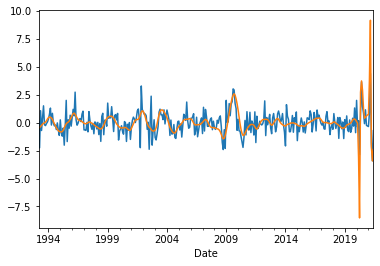

In [36]:
import matplotlib.pyplot as plt
normalized_df['PMI_roc'].plot()
normalized_df['cli_roc'].plot()
plt.show()

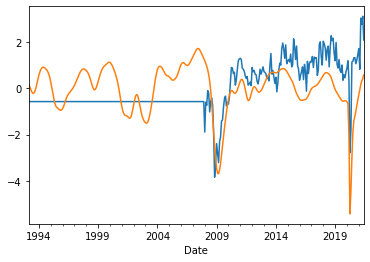

In [37]:
normalized_df['ISMServices'].plot()
normalized_df['cli'].plot()
plt.show()

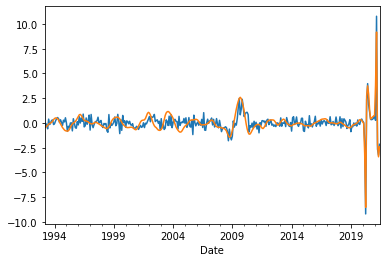

In [38]:
normalized_df['IndPro_roc'].plot()
normalized_df['cli_roc'].plot()
plt.show()

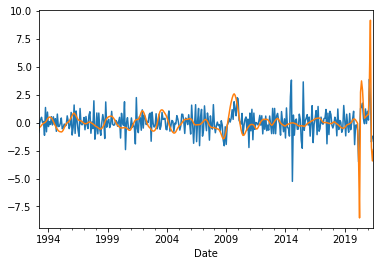

In [39]:
normalized_df['DurGoods_roc'].plot()
normalized_df['cli_roc'].plot()
plt.show()

# Dickey Fuller Test for Stationarity


In [40]:
#Test-statistic for p-value
from statsmodels.tsa.stattools import adfuller

In [41]:
def dfuller(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("NON-Stationary")

In [42]:
dfuller(normalized_df['cli'])

Test-Statistic: -4.429836282662767
P-value: 0.0002627495856557062
Stationary


In [43]:
dfuller(normalized_df['DurGoods_roc'])

Test-Statistic: -8.75716175947363
P-value: 2.7356095402714065e-14
Stationary


In [44]:
# Gamma Distribution - Exponential, ChiSquared Distrubtions, Erlang Distributions
dfuller(np.random.gamma(1,1,100))

Test-Statistic: -10.42034538931001
P-value: 1.7111462093407497e-18
Stationary


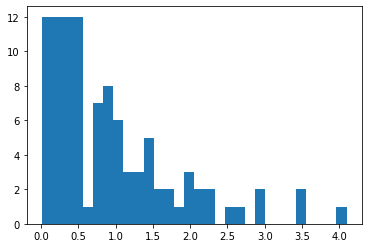

In [45]:
# What Gamma Distributions look like
s = np.random.gamma(1, 1, 100)
plt.hist(s, bins=30);

# Arima - ACF AutoCorrelation Function (Hyperparameter)

In [46]:
# Plotting the ACF
# Applies different lags within a Time Series and looks at the correlations
# ACF plots also plot confidence intervals (95%)
# q = Moving Average
from statsmodels.graphics.tsaplots import plot_acf

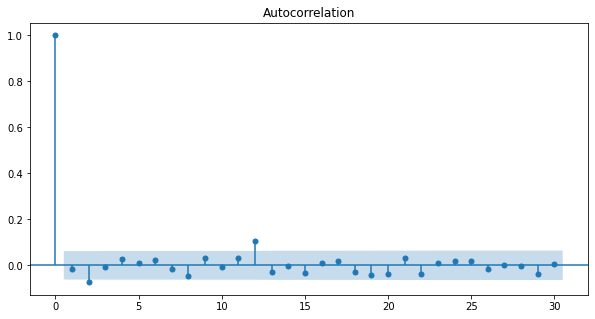

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(np.random.randn(1000), ax=ax);

In [48]:
# MA1 process
errors = 0.1 * np.random.randn(1000)
ma1 = []
for i in range(1000):
    if i >= 1:
        x = 0.5 * errors[i-1] + errors[i]
    else:
        x = errors[i]
    ma1.append(x)
ma1 = np.array(ma1)

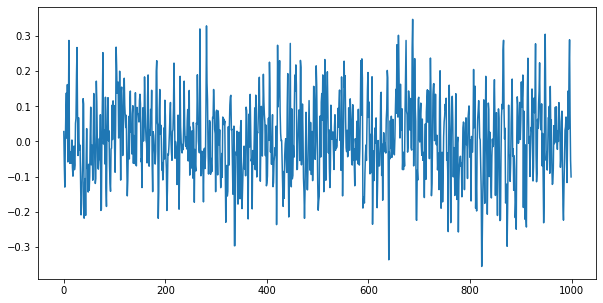

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(ma1);

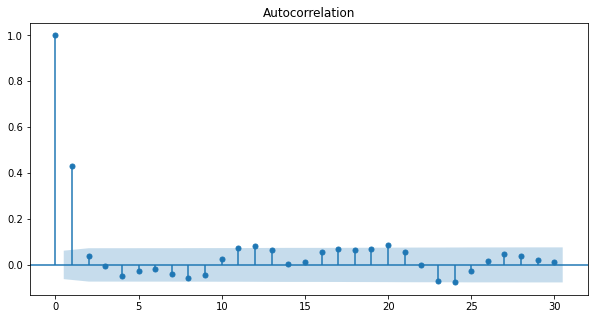

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(ma1, ax=ax);

In [51]:
# MA2 Process
errors = 0.1 * np.random.randn(1000)
ma2 = []
for i in range(1000):
    x = 0.5 * errors[i-1] - 0.3 * errors[i-2] + errors[i]
    ma2.append(x)
ma2 = np.array(ma2)

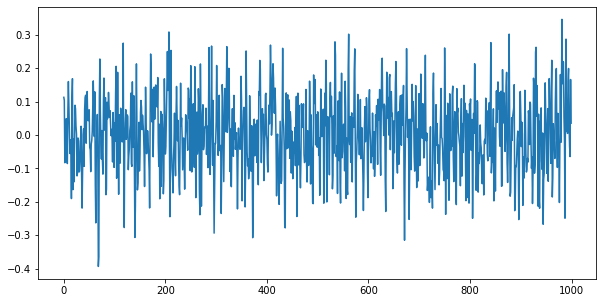

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(ma2);

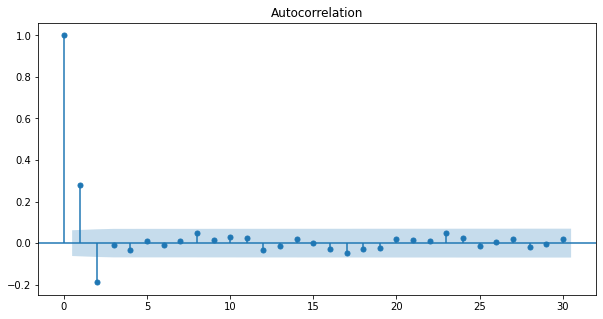

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(ma2, ax=ax);

In [54]:
# MA2 Process
errors = 0.1 * np.random.randn(1000)
ma3 = []
for i in range(1000):
    x = 0.5 * errors[i-1] - 0.3 * errors[i-2] + 0.7 * errors[i-3] + errors[i]
    ma3.append(x)
ma3 = np.array(ma3)

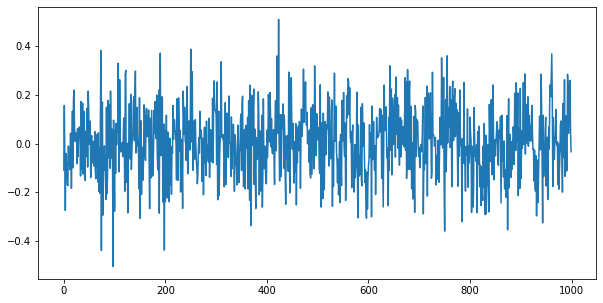

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(ma3);

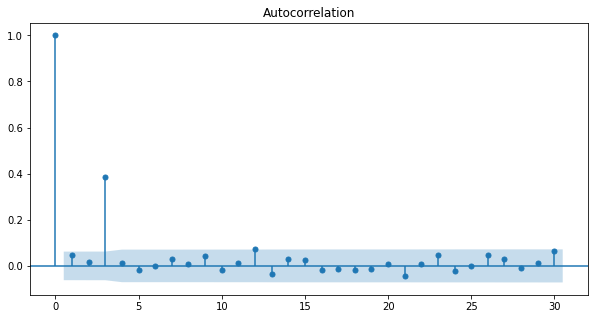

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(ma3, ax=ax);

In [57]:
# MA6 Process
errors = 0.1 * np.random.randn(1000)
ma6 = []
for i in range(1000):
    x = 0.5 * errors[i-1] - 0.3 * errors[i-2] + 0.7 * errors[i-3] + \
    0.2 * errors[i-4] - 0.8 * errors[i-5] - 0.9 * errors[i-6] + errors[i]
    ma6.append(x)
ma6 = np.array(ma6)

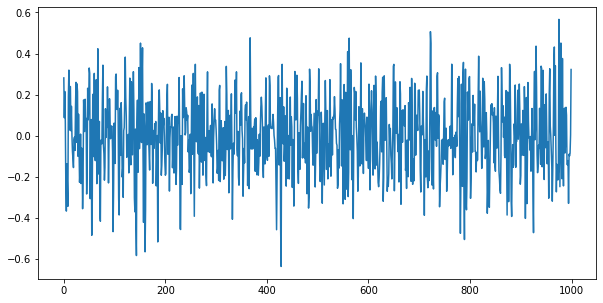

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(ma6)

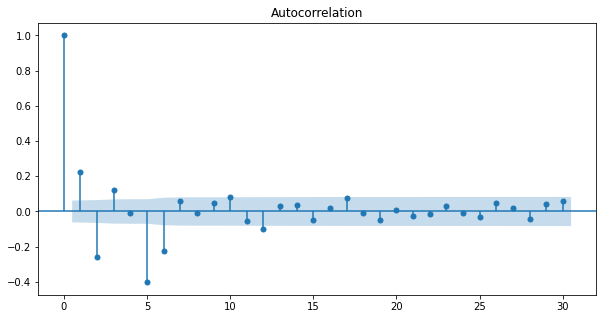

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(ma6, ax=ax);

# Arima - PACF PartialAutoCorrelation Function (Hyperparameter)

In [60]:
# choosing p is similar to choosing q
from statsmodels.graphics.tsaplots import plot_pacf

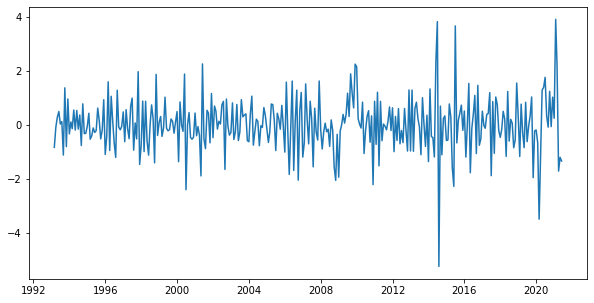

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(normalized_df['DurGoods_roc'])
plt.show()

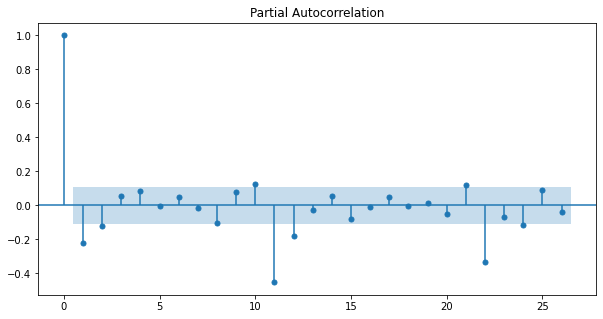

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(normalized_df['DurGoods_roc'], ax=ax)
plt.show()

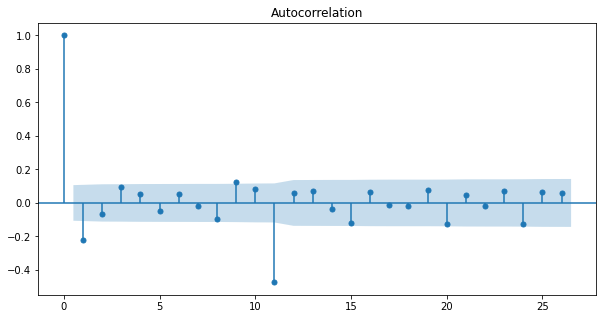

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(normalized_df['DurGoods_roc'], ax=ax)
plt.show()

In [64]:
# AR1 process
x1 = [0]
for i in range(1000):
    x = 0.5 * x1[-1] + 0.1 * np.random.randn()
    x1.append(x)
x1 = np.array(x1)

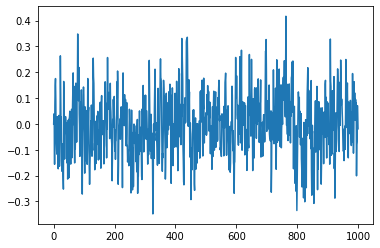

In [65]:
plt.plot(x1);

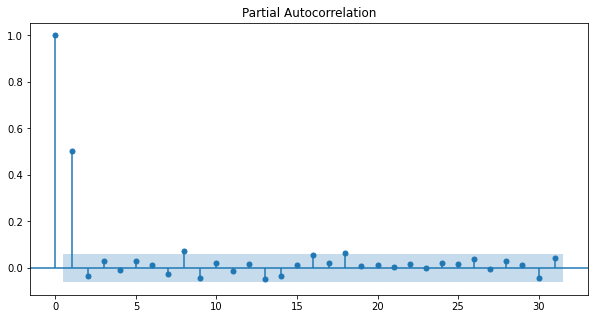

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(x1, ax=ax);

In [67]:
# AR2 process
x2 = [0,0]
for i in range(1000):
    x = 0.5 * x2[-1] - 0.3 * x2[-2] + 0.1 * np.random.randn()
    x2.append(x)
x2 = np.array(x2)

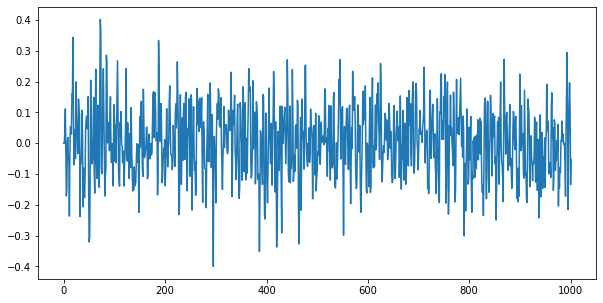

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(x2)
plt.show()

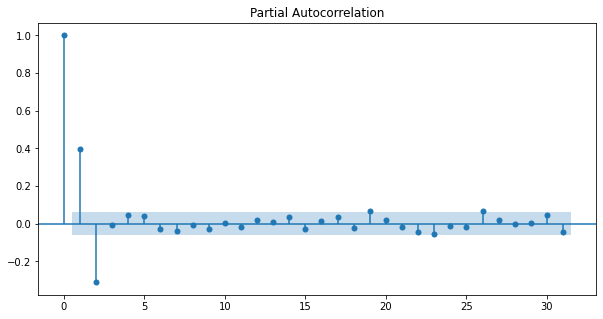

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(x2, ax=ax);

In [70]:
# AR5 Process
x5 = [0,0,0,0,0]
for i in range(1000):
    x = 0.5 * x5[-1] - 0.3 * x5[-2] - 0.6 * x5[-5] + 0.1 * np.random.rand()
    x5.append(x)
x5 = np.array(x5)

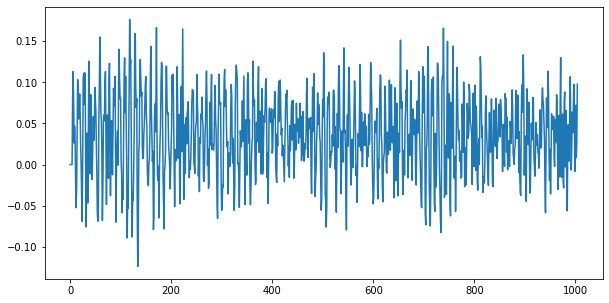

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(x5);

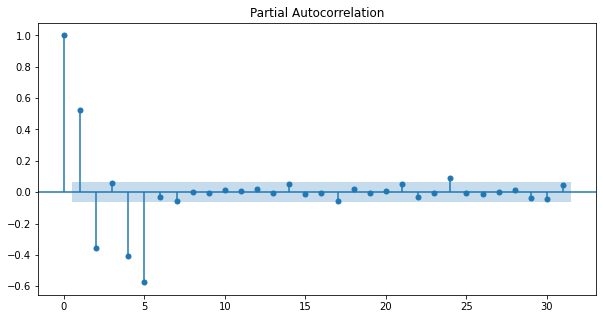

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(x5, ax=ax);

# Arima Modeling

In [73]:
# ToDO: pipenv install pmdarima 
# or is it - from statsmodels.tsa.arima.model import ARIMA
# import pmdarima as pm
# !pip install pmdarima

In [74]:
# model = pm.auto_arima(data, seasonal=True, m=12)

# # return predictgions and confidence intervals
# test_pred, confint = model.predict(
# n_periods=Ntest, return_conf_int=True)

## VARMA modeling - Vector Autoregressive Moving Average 

In [75]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

In [76]:
# ToDo: Add the `TSpread` = 10year - 3 year or 2 year or 3 month
normalized_df.tail()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,1.630429,0.921489,1.299209,0.869434,0.939842,0.832229,-1.816410,-0.462456,-0.078005,-1.708415,-0.035216,0.819835,0.466277,3.818140,0.740079,0.284769,-3.150273,-1.135440,0.261424,-2.137205,1.473634,0.209719,0.316218,3.899994,0.050817,1.654488,-0.186655,0.906246,0.187186,0.243308,2.010368,-1.747475,0.396083,2.300799,-0.959031,1.726664,-1.306819,-1.678500,3.671498,-0.676812,-3.421067,-0.002126,-1.843993,-0.421724,-2.929446
2021-03-01,2.422265,1.672608,1.919482,4.407017,1.580433,3.050470,4.644365,2.548067,8.512746,4.409576,0.171509,0.731630,1.653852,9.177355,3.854152,0.556876,2.361322,0.318498,10.775623,4.121352,1.571378,0.215591,2.912539,2.161440,4.178334,1.800558,0.429266,1.250197,1.833648,0.695802,2.616627,5.844232,5.029704,10.014049,7.570537,1.971427,4.306040,2.531033,11.192313,7.319523,-2.328813,1.263941,-1.075301,1.699842,0.735863
2021-04-01,1.610126,-1.663462,2.944804,-1.804038,2.614580,2.786394,-0.516373,7.051138,-2.230546,6.598715,0.340334,0.594423,4.631934,-2.178647,9.684755,0.521991,-0.420297,3.987951,-2.647973,10.412762,1.515799,-0.226559,4.375990,-1.724140,2.352349,2.050302,0.779185,2.485953,0.066995,2.514608,2.670696,0.274618,9.764547,-5.968785,7.737143,2.026581,0.650023,8.298878,-4.336459,10.034189,-1.236560,1.247794,1.975082,-1.044652,2.917330
2021-05-01,1.711643,0.192088,2.706920,-3.410460,-0.613934,3.129693,0.605380,5.673575,-4.278911,-2.023221,0.420268,0.278356,3.838016,-3.424133,-2.605892,0.603360,0.607063,3.130550,-3.275190,-2.443836,1.756196,0.624900,3.479412,-1.213869,-1.452023,2.103702,0.096130,2.244927,-0.926161,-0.498341,2.566887,-1.134296,4.608248,-3.827557,-8.449762,2.022133,-0.426601,4.899160,-3.787746,-5.930087,-0.144306,1.231648,0.059158,0.419809,-1.822102
2021-06-01,1.589822,-0.285704,0.980408,-0.714894,-4.418299,2.099795,-1.909402,0.786420,-1.398000,-7.169872,0.589094,0.591973,2.787078,-2.414235,-3.450667,0.599192,-0.149568,1.558809,-2.159727,-4.469790,1.827263,0.130771,2.310472,-1.348964,-1.890880,2.171359,0.142681,1.711359,-0.482480,-1.094309,2.599547,0.085080,2.688237,-0.345845,-3.154309,2.072227,0.549118,2.929906,-0.445362,-3.442590,-0.963496,-0.915821,-1.789418,0.412071,-1.755661


In [77]:
# If using quarterly data use the function below
# def parse_date(data):
#     year, quarter = data.split(':')
#     moneth = (int(quarter) - 1) * 3 + 1
#     s = f"{year}-{month}"
#     return datetime.strptime(s, "%Y-%m")

In [78]:
# normalized_df['Date'] = normalized_df['Date'].apply(parse_date)

In earlier cell, using the Dicky Fuller Test we discovered that it is most likely Stationary.


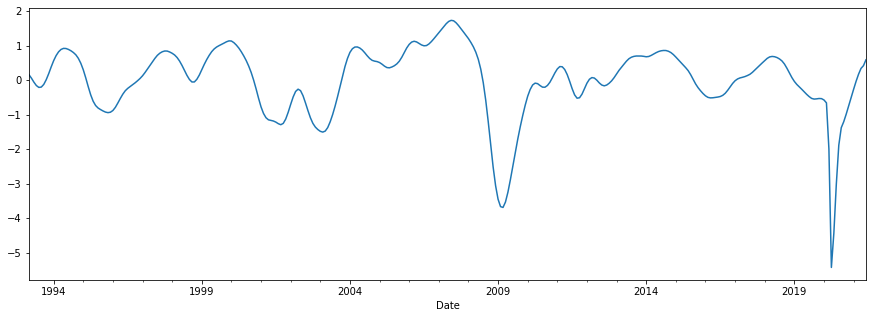

In [79]:
normalized_df['cli'].plot(figsize=(15, 5));
print("In earlier cell, using the Dicky Fuller Test we discovered that it is most likely Stationary.")

In [80]:
normalized_df.shape

(340, 45)

In [81]:
momGDP.head()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-03-01,53.5,-3.080,-2.015,0.604,-6.76,50.0,0.0,0.0,0.0,0.0,100.035,-0.099,0.683,-0.266,-0.29,61.976,-0.195,4.160,-0.771,-1.28,126762.0,-1.624,5.613,-5.273,-6.89,36895.0,-0.181,4.643,-2.242,-4.53,172306.0,-0.828,5.244,-1.433,-0.56,4352.5,-0.064,5.720,-0.416,-0.52,31.253,0.0,0.0,0.0,0.0
1993-04-01,50.2,-6.168,-4.563,-12.093,-2.55,50.0,0.0,0.0,0.0,0.0,99.890,-0.145,0.369,-0.251,-0.31,62.301,0.525,4.105,-0.064,-0.05,127395.0,0.499,2.350,-0.582,-3.26,37729.0,2.260,4.826,-0.015,0.18,176749.0,2.579,7.310,1.999,2.07,4393.4,0.940,6.339,0.286,0.62,31.253,0.0,0.0,0.0,0.0
1993-05-01,51.2,1.992,-8.079,5.816,-3.52,50.0,0.0,0.0,0.0,0.0,99.721,-0.170,0.093,-0.202,-0.28,62.233,-0.109,3.382,-0.437,-0.72,126529.0,-0.680,0.562,1.721,-1.79,37869.0,0.371,2.874,0.765,-1.95,178426.0,0.949,7.737,0.664,0.43,4422.4,0.660,6.349,0.209,0.01,31.253,0.0,0.0,0.0,0.0
1993-06-01,49.6,-3.125,-7.463,-3.733,0.62,50.0,0.0,0.0,0.0,0.0,99.578,-0.143,-0.082,-0.132,-0.18,62.126,-0.172,2.866,-1.122,-0.52,130212.0,2.911,6.006,3.068,5.44,38381.0,1.352,4.677,1.444,1.80,178157.0,-0.151,7.274,-0.859,-0.46,4440.0,0.398,6.294,-0.264,-0.05,31.253,0.0,0.0,0.0,0.0
1993-07-01,50.2,1.210,-6.865,2.134,0.60,50.0,0.0,0.0,0.0,0.0,99.499,-0.079,-0.150,-0.069,-0.07,62.291,0.266,2.166,0.730,-0.70,128111.0,-1.614,4.504,0.167,-1.50,38915.0,1.391,6.241,2.751,1.56,180743.0,1.452,8.063,1.117,0.79,4468.9,0.651,6.281,0.267,-0.01,31.253,0.0,0.0,0.0,0.0


In [82]:
momGDP.corr()

,PMI,PMI%qoq,PMI_%yoy,PMI_roc,PMI_roc%yoy,ISMServices,ISMServices%qoq,ISMServices_%yoy,ISMServices_roc,ISMServices_roc%yoy,cli,cli%qoq,cli%yoy,cli_roc,cli_roc%yoy,Ind_Pro,IndPro%qoq,IndPro%yoy,IndPro_roc,IndPro_roc%yoy,DurGoods,DurGoods%qoq,DurGoods%yoy,DurGoods_roc,DurGoods_roc%yoy,NewOrders,NewOrders%qoq,NewOrders%yoy,NewOrders_roc,NewOrders_roc%yoy,RetailSales,RetailSales%qoq,RetailSales%yoy,RetailSales_roc,RetailSales_roc%yoy,PCE,PCE%qoq,PCE%yoy,PCE_roc,PCE_roc%yoy,WeeklyHours,WeeklyHours%qoq,WeeklyHours%yoy,WeeklyHours_roc,WeeklyHours_roc%yoy
PMI,1.000000,0.185723,0.695038,0.008006,0.028280,0.539573,0.095159,0.506211,0.057260,0.041056,0.620122,0.257704,0.777210,0.078781,0.102099,0.121209,0.298986,0.530101,0.224006,0.234690,0.269258,0.140848,0.606057,0.095533,0.074980,0.179219,0.183619,0.592224,0.123677,0.116285,0.227294,0.124865,0.533041,0.084158,0.073553,0.196558,0.149861,0.341579,0.145756,0.136416,-0.062261,0.008315,0.182911,0.002572,-0.004568
PMI%qoq,0.185723,1.000000,0.237452,0.713579,0.678850,0.049566,0.369423,0.060271,0.264994,0.202004,-0.070328,0.496813,0.041723,0.462590,0.365537,-0.038882,0.347473,-0.134550,0.356096,0.240320,-0.064663,0.064332,-0.110654,0.123373,0.008571,-0.088053,-0.011817,-0.159872,0.082615,-0.019204,0.031749,0.272950,-0.007611,0.271993,0.145355,0.025885,0.295707,-0.092631,0.289892,0.160133,-0.012511,0.023128,0.018579,0.022775,0.027196
PMI_%yoy,0.695038,0.237452,1.000000,-0.012069,0.199040,0.228705,0.108660,0.628324,0.041177,0.118529,0.270089,0.291738,0.780503,0.159625,0.283045,-0.012699,0.250628,0.295394,0.271314,0.367145,-0.014083,0.130523,0.371127,0.159564,0.151927,-0.052816,0.161409,0.241854,0.206755,0.206095,0.071570,0.089451,0.349294,0.055841,0.105014,0.057631,0.107768,0.173238,0.105664,0.165857,-0.079961,0.012902,0.101777,0.004371,0.012139
PMI_roc,0.008006,0.713579,-0.012069,1.000000,0.518363,-0.018393,0.263560,-0.101340,0.357018,0.230153,-0.124628,0.383975,-0.121817,0.580832,0.421458,-0.045235,0.252082,-0.261601,0.423911,0.230916,-0.073081,-0.009668,-0.213829,0.071925,0.084543,-0.090590,-0.077524,-0.252824,0.002018,0.001229,0.011964,0.234126,-0.081950,0.350881,0.271776,0.008997,0.229727,-0.161075,0.357458,0.241603,-0.021742,0.029307,-0.018986,0.033880,0.061735
PMI_roc%yoy,0.028280,0.678850,0.199040,0.518363,1.000000,-0.033682,0.193892,0.030920,0.212191,0.339338,-0.110397,0.338756,-0.042836,0.445314,0.519154,-0.041493,0.173769,-0.201349,0.279853,0.337606,-0.074935,-0.003609,-0.208935,0.131102,0.026234,-0.063143,0.050804,-0.227139,0.151300,0.040110,0.016025,0.165110,0.014774,0.142591,0.260621,0.012404,0.167799,-0.066870,0.162461,0.270859,0.005755,0.047963,0.038713,0.031841,0.080489
ISMServices,0.539573,0.049566,0.228705,-0.018393,-0.033682,1.000000,0.224456,0.489877,0.122369,0.122137,0.271064,0.194118,0.368005,0.084934,0.125265,0.422905,0.186511,0.202186,0.149751,0.181248,0.657336,0.073691,0.336940,0.034092,0.034878,0.537341,0.062742,0.227391,0.052493,0.053545,0.712212,0.127528,0.396990,0.062909,0.077585,0.690036,0.139614,0.162923,0.122267,0.152434,-0.178269,-0.003896,0.042511,-0.010530,0.015698
ISMServices%qoq,0.095159,0.369423,0.108660,0.263560,0.193892,0.224456,1.000000,0.257301,0.742156,0.665496,-0.003439,0.515854,0.051383,0.471399,0.391841,0.002794,0.494108,-0.015465,0.483242,0.372474,0.005891,0.127781,0.009505,0.116848,0.075965,-0.016418,-0.004558,-0.048224,0.056430,-0.002751,0.055974,0.527258,0.125338,0.420016,0.357152,0.041312,0.548514,0.045542,0.472211,0.401298,-0.015664,-0.005327,0.019868,0.011191,0.076339
ISMServices_%yoy,0.506211,0.060271,0.628324,-0.101340,0.030920,0.489877,0.257301,1.000000,-0.016624,0.342379,0.293184,0.263342,0.689034,0.063233,0.313959,0.068391,0.269925,0.465995,0.177769,0.417286,0.106951,0.097574,0.513947,0.053860,0.106964,0.109321,0.111030,0.350189,0.125084,0.133005,0.143474,0.124930,0.592124,-0.043741,0.158897,0.119715,0.167798,0.453661,0.036828,0.278359,0.015321,0.030897,0.211308,0.003309,0.039964
ISMServices_roc,0.057260,0.264994,0.041177,0.357018,0.212

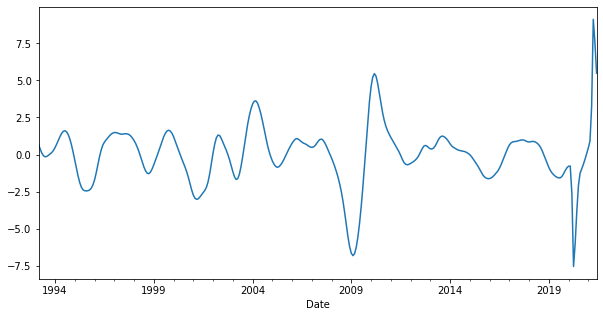

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
momGDP['cli%yoy'].plot();

In [84]:
# cols_drop = ['ISMServices', 'ISMServices%qoq', 'ISMServices_%yoy', 
#              'ISMServices_roc', 'ISMServices_roc', 'ISMServices_roc%yoy']
# normalized_df1 = normalized_df.drop(cols_drop, axis=1)

# scaled_arr = scaler.fit_transform(momGDP)

# Converting the array back to a DataFrame and using the same column headers and index header
# normalized_df = pd.DataFrame(scaled_arr, index=momGDP.index, columns = momGDP.columns)
# Rounding the DataFrame to 3 decimal places
# normalized_df.round(3)
momGDP['cli_growth'] = np.log(momGDP['cli']).diff()

#'cli%yoy'
# cols = ["cli_roc%yoy", "IndPro_roc%yoy", "PMI_roc%yoy","NewOrders_roc%yoy", "RetailSales_roc%yoy", "PCE_roc%yoy", "DurGoods_roc%yoy"]
cols = ["cli_roc%yoy", "IndPro_roc%yoy", "PCE_roc%yoy"]


df = momGDP[cols].copy()
df = df.round(3)
# Calculating what the train-test-split will be
# Ntest = int(df.shape[0] * .80)

Ntest = 3
# Making the train-test-split
train = df.iloc[:-Ntest].copy()
test = df.iloc[-Ntest:].copy()

# train = df.iloc[:-Ntest].copy()
# test = df.iloc[-Ntest:].copy()

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

train.dropna(inplace=True)

df.loc[train_idx, :] = train
df.loc[test_idx, :] = test

In [85]:
train.tail()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
Date,,,
2020-11-01,0.671974,-0.087079,-0.720460
2020-12-01,0.752620,0.487777,-0.509948
2021-01-01,0.772782,1.209853,1.956043
2021-02-01,0.913913,-2.723005,-0.893380
2021-03-01,4.704294,5.289930,9.692340


In [86]:
train.corr()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
cli_roc%yoy,1.000000,0.721907,0.669005
IndPro_roc%yoy,0.721907,1.000000,0.682266
PCE_roc%yoy,0.669005,0.682266,1.000000


In [87]:
test.head()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
Date,,,
2021-04-01,11.801177,13.344928,13.286071
2021-05-01,-3.158730,-3.115590,-7.847776
2021-06-01,-4.186972,-5.709454,-4.554776


In [88]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [89]:
train.corr()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
cli_roc%yoy,1.000000,0.721907,0.669005
IndPro_roc%yoy,0.721907,1.000000,0.682266
PCE_roc%yoy,0.669005,0.682266,1.000000


In [90]:
# dfuller(train['PMI'])
# dfuller(train['PMI%qoq'])
# dfuller(train['PMI_%yoy'])
# dfuller(train['PMI_roc'])

In [91]:
# plot_acf(train['cli_growth']);
# plot_pacf(train['cli_growth']);
# dfuller(train['cli_growth'])

In [92]:
# plot_acf(train['PMI']);
# dfuller(train['PMI'])

In [93]:
# plot_acf(train['PMI_roc']);
# plot_pacf(train['PMI_roc'])
# dfuller(train['PMI_roc'])

In [94]:
# plot_acf(train['PMI_%yoy']);
# plot_pacf(train['PMI_%yoy'])
# dfuller(train['PMI_%yoy'])

In [95]:
# plot_acf(train['PMI%qoq']);
# plot_pacf(train['PMI%qoq']);
# dfuller(train['PMI%qoq'])

In [96]:
# plot_acf(train['IndPro_roc']);
# plot_pacf(train['IndPro_roc']);
# dfuller(train['IndPro_roc'])

In [97]:
# plot_acf(train['IndPro_roc%yoy']);
# plot_pacf(train['IndPro_roc%yoy']);
# dfuller(train['IndPro_roc%yoy'])

In [98]:
# Plotting the ACF
# Applies different lags within a Time Series and looks at the correlations
# ACF plots also plot confidence intervals (95%)
# q = Moving Average

# choosing p is similar to choosing q --> PACF

In [99]:
df.index

DatetimeIndex(['1993-03-01', '1993-04-01', '1993-05-01', '1993-06-01',
               '1993-07-01', '1993-08-01', '1993-09-01', '1993-10-01',
               '1993-11-01', '1993-12-01',
               ...
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', name='Date', length=340, freq='MS')

In [100]:
train.index[-1]

Timestamp('2021-03-01 00:00:00', freq='MS')

In [101]:
test.index[-1]

Timestamp('2021-06-01 00:00:00', freq='MS')

In [102]:
train.tail(16)

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
Date,,,
2019-12-01,0.349388,-0.171205,0.843340
2020-01-01,0.188095,0.354579,0.129104
2020-02-01,0.006641,0.410662,-0.006224
2020-03-01,-3.763578,-2.975381,-6.111057
2020-04-01,-9.912867,-10.083970,-9.576978
2020-05-01,3.131689,2.597920,5.218971
2020-06-01,4.381708,4.217332,4.061158
2020-07-01,3.494598,2.864317,0.926041
2020-08-01,1.639730,0.592934,0.467426


In [103]:
train.corr()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
cli_roc%yoy,1.000000,0.721907,0.669005
IndPro_roc%yoy,0.721907,1.000000,0.682266
PCE_roc%yoy,0.669005,0.682266,1.000000


In [104]:
from datetime import datetime

p = 2
q = 1
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
res = model.fit(maxiter=500)
print("Duration:", datetime.now() - t0)

C:\Users\dabor\.virtualenvs\engineering-MbMuV8uz\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\dabor\.virtualenvs\engineering-MbMuV8uz\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:08:30.454503


In [105]:
fcast = res.get_forecast(Ntest+3)

In [106]:
train.describe()

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
count,3.370000e+02,3.370000e+02,337.000000
mean,1.317772e-18,-6.588861e-18,0.000000
std,1.001487e+00,1.001487e+00,1.001487
min,-9.912867e+00,-1.008397e+01,-9.576978
25%,-4.369144e-01,-4.516222e-01,-0.254327
50%,-7.400564e-02,5.312958e-02,-0.006224
75%,3.292264e-01,3.966412e-01,0.241878
max,4.704294e+00,5.289930e+00,9.692340


In [107]:
# cols = ['cli_growth','IndPro_roc', "IndPro%qoq", "cli_roc"]

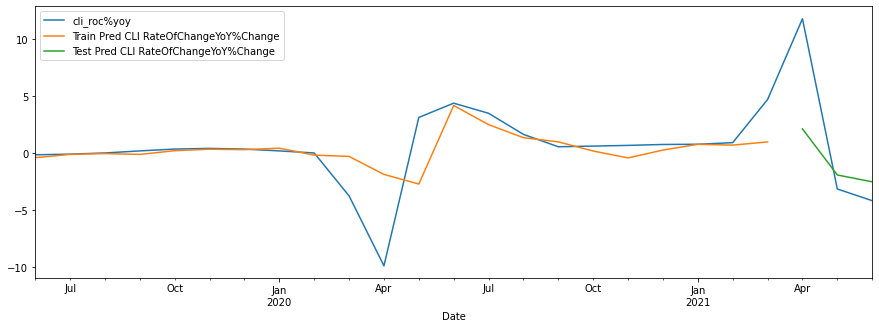

In [108]:
df.loc[train_idx, "Train Pred CLI RateOfChangeYoY%Change"] = res.fittedvalues['cli_roc%yoy']
df.loc[test_idx, "Test Pred CLI RateOfChangeYoY%Change"] = fcast.predicted_mean['cli_roc%yoy']
plot_cols = ['cli_roc%yoy', "Train Pred CLI RateOfChangeYoY%Change", "Test Pred CLI RateOfChangeYoY%Change"]
df[-25:][plot_cols].plot(figsize=(15,5));

In [109]:
# df.loc[train_idx, "Train Pred IndPro_roc"] = res.fittedvalues['IndPro_roc%yoy']
# df.loc[test_idx, "Test Pred IndPro_roc"] = fcast.predicted_mean['IndPro_roc%yoy']
# plot_cols = ['IndPro_roc%yoy', "Train Pred IndPro_roc", "Test Pred IndPro_roc"]
# df[-200:][plot_cols].plot(figsize=(15,5));

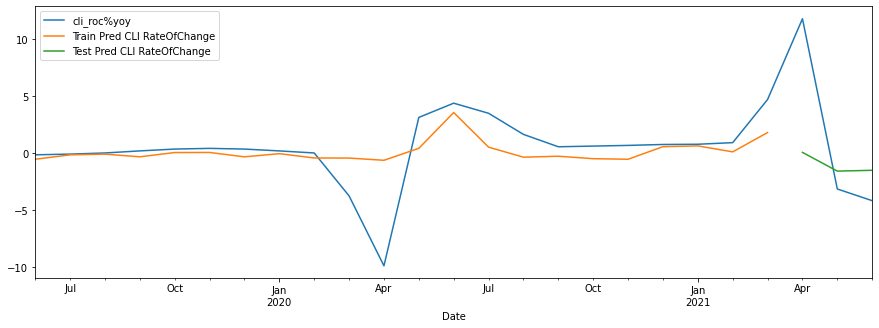

In [110]:
df.loc[train_idx, "Train Pred CLI RateOfChange"] = res.fittedvalues['PCE_roc%yoy']
df.loc[test_idx, "Test Pred CLI RateOfChange"] = fcast.predicted_mean['PCE_roc%yoy']
plot_cols = ['cli_roc%yoy', "Train Pred CLI RateOfChange", "Test Pred CLI RateOfChange"]
df[-25:][plot_cols].plot(figsize=(15,5));

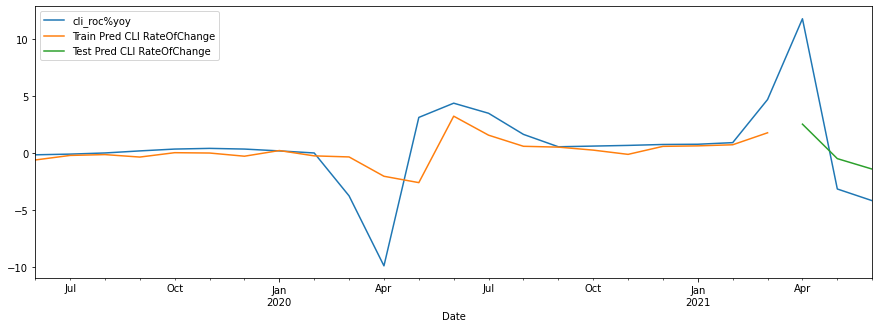

In [111]:
df.loc[train_idx, "Train Pred CLI RateOfChange"] = res.fittedvalues['IndPro_roc%yoy']
df.loc[test_idx, "Test Pred CLI RateOfChange"] = fcast.predicted_mean['IndPro_roc%yoy']
plot_cols = ['cli_roc%yoy', "Train Pred CLI RateOfChange", "Test Pred CLI RateOfChange"]
df[-25:][plot_cols].plot(figsize=(15,5));

In [112]:
res.summary()

Dep. Variable:,"['cli_roc%yoy', 'IndPro_roc%yoy', 'PCE_roc%yoy']",No. Observations:,337
Model:,"VARMA(2,1)",Log Likelihood,-931.555
,+ intercept,AIC,1935.111
Date:,"Wed, 04 Aug 2021",BIC,2072.634
Time:,17:08:26,HQIC,1989.926
Sample:,03-01-1993,,
,- 03-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.04, 0.05, 0.04",Jarque-Bera (JB):,"82203.80, 182.87, 1181.50"
Prob(Q):,"0.84, 0.82, 0.84",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"17.45, 1.35, 1.48",Skew:,"-2.90, -0.73, 0.58"


In [113]:
irfs = res.impulse_responses(steps=10)
irfs

,cli_roc%yoy,IndPro_roc%yoy,PCE_roc%yoy
0,1.000000,0.000000,0.000000
1,0.747032,0.628454,0.645130
2,0.647757,0.309556,0.054696
3,0.401725,0.246973,0.054788
4,0.308559,0.199186,0.028968
5,0.234755,0.217022,0.081831
6,0.166575,0.216963,0.094709
7,0.081697,0.199085,0.091811
8,-0.008026,0.164332,0.075984
9,-0.093379,0.122992,0.059098


In [114]:
from sklearn.metrics import r2_score
for col in cols:
    y_true = df.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R squared:", r2_score(y_true, y_pred))
    
    y_true = df.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))

Train R squared: 0.5374845509670412


ValueError: Found input variables with inconsistent numbers of samples: [3, 6]

## VAR modeling

In [ ]:
# Creating a VAR object
model = VAR(train)

In [ ]:
lag_order_results = model.select_order(maxlags=12)
lag_order_results.selected_orders

In [ ]:
# BIC --> Bayesian
results = model.fit(maxlags=12, ic='bic')

In [ ]:
# Value is a lag_order of 13 because I used 'bic'
lag_order = results.k_ar

In [ ]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

In [ ]:
# df.loc[train_idx, "Train Pred CLI RateOfChange"] = results.fittedvalues['cli%yoy']
# df.loc[test_idx, "Test Pred CLI RateOfChange"] = fcast[:,0]
# plot_cols = ['cli%yoy', "Train Pred CLI RateOfChange", "Test Pred CLI RateOfChange"]
# df.iloc[-50:][plot_cols].plot(figsize=(15,5));

In [ ]:
# df.loc[train_idx, "Train Pred CLI RateOfChange"] = results.fittedvalues['PMI_%yoy']
# df.loc[test_idx, "Test Pred CLI RateOfChange"] = fcast[:,0]
# plot_cols = ['PMI_%yoy', "Train Pred CLI RateOfChange", "Test Pred CLI RateOfChange"]
# df.iloc[-50:][plot_cols].plot(figsize=(15,5));

In [ ]:
df.tail(1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
df.iloc[-24:]['cli_roc%yoy'].plot(label="cli_roc%yoy")
df.iloc[-24:]['IndPro_roc%yoy'].plot(label='IndPro_roc%yoy')
df.iloc[-24:]['PCE_roc%yoy'].plot(label="PCE_roc%yoy")
# df.iloc[-10:]['PMI_roc%yoy'].plot()
# df.iloc[-10:]['NewOrders_roc%yoy'].plot()
# df.iloc[-10:]['RetailSales_roc%yoy'].plot()
# df.iloc[-10:]['DurGoods_roc%yoy'].plot();
# Adds a legened
plt.legend(loc="upper left")
plt.show()

In [ ]:
test.tail()